In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
import os

In [2]:
# here take as input a BBL 
# see if data file exists, if so, get hash of docids
# do first data pull from open data, compare hash of docids
# if match, move ahead with saved data, if not, pull new data and re-save
# for now just check if file exists

In [3]:
def get_and_cache_bbl_data(bbl=(4,528,50),filename='coopdata.csv'):
    if os.path.isfile(filename):
        print 'reading data from cache...'
        df = pd.read_csv(filename)
        print len(df),'records'
        return df
    else:
        print 'no cache found, pulling data from web...'
        url='https://data.cityofnewyork.us/resource/8h5j-fqxa.csv?borough='
        url+=str(bbl[0])+'&block='+str(bbl[1])+'&lot='+str(bbl[2])
        df=pd.read_table(url,sep=',')
        docids = df['DOCUMENT ID']
        urlbase="https://data.cityofnewyork.us/resource/bnx9-e6tj.csv?$where=document_id='"
        l = len(docids)
        n = l // 100 
        masterlist = [] 
        for i in range(n+1):
            if i < n:
                url = urlbase + "'%20or%20document_id='".join(docids[i*100:(i+1)*100]) + "'"
                #print url 
                masterlist.append(pd.read_table(url,sep=','))
            else:
                url=urlbase + "'%20or%20document_id='".join(docids[i*100:l]) + "'"
                #print url
                masterlist.append(pd.read_table(url,sep=',')) 
        masters = pd.concat(masterlist)
        mergeddf = pd.merge(df,masters,on=['DOCUMENT ID'])
        mergeddf.columns = mergeddf.columns.str.replace(' ','')
        mergeddf.columns = mergeddf.columns.str.replace('.','')
        mergeddf.columns = mergeddf.columns.str.lower()
        print 'saving to file',filename
        mergeddf.to_csv(filename)
        print len(mergeddf), 'records'
        return mergeddf

In [4]:
mergeddf=get_and_cache_bbl_data(filename='coopdata.csv')

reading data from cache...
185 records


In [5]:
mergeddf.propertytype.head(10)

0    SP
1    SP
2    SP
3    SP
4    PA
5    SP
6    SP
7    SP
8    PA
9    SP
Name: propertytype, dtype: object

In [6]:
#for now limit to just sales so don't have to deal with missing dates on other record types
#todo would be to do a 'bestdate' that would take docdate if its there or recordedfiled if not 
sales=mergeddf[mergeddf.doctype.str.startswith('RPTT')]
sales.head()

,Unnamed: 0,documentid,recordtype_x,borough_x,block,lot,easement,partiallot,airrights,subterraneanrights,...,doctype,docdate,docamount,recorded/filed,modifieddate,reelyear,reelnbr,reelpage,%transferred,goodthroughdate_y
0,0,2015090300204001,L,4,528,50,N,E,N,N,...,RPTT&RET,08/25/2015,418000,09/16/2015,09/16/2015,0,0,0,100,09/30/2015
1,1,2011012100554001,L,4,528,50,N,E,N,N,...,RPTT&RET,01/24/2011,300000,02/08/2011,02/08/2011,0,0,0,100,07/31/2015
2,2,2013112100798001,L,4,528,50,N,E,N,N,...,RPTT&RET,11/14/2013,325000,12/03/2013,12/03/2013,0,0,0,100,07/31/2015
3,3,2010090101085001,L,4,528,50,N,E,N,N,...,RPTT&RET,09/01/2010,332500,09/13/2010,09/13/2010,0,0,0,100,07/31/2015
5,5,2012072701175001,L,4,528,50,N,E,N,N,...,RPTT&RET,07/17/2012,315000,08/07/2012,08/07/2012,0,0,0,100,07/31/2015


In [7]:
#fix the date field
from datetime import datetime
sales['date'] = [ datetime.strptime(date_string, '%m/%d/%Y') for date_string in sales['docdate'] ]
sales.date.head()

/Users/helene/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


0   2015-08-25
1   2011-01-24
2   2013-11-14
3   2010-09-01
5   2012-07-17
Name: date, dtype: datetime64[ns]

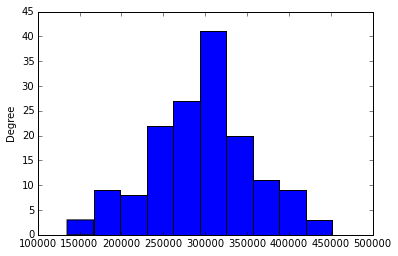

In [9]:
#get rid of zero and low dollar records
sales = sales[sales.docamount>100000]
sales.docamount.plot(kind='hist')

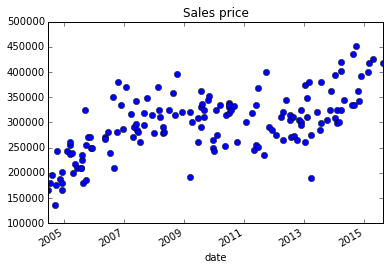

In [10]:
#but this works? 
sales.plot(x='date',y='docamount',style='o',legend=False,title='Sales price')

In [142]:
sales.streetnumber.value_counts()

33-43    26
33-65    25
33-60    24
33-55    21
33-64    18
33-68    14
33-47    13
3343      4
3368      3
3365      2
3355      1
3360      1
3364      1
dtype: int64

In [12]:
sales['street']=[int(s[0:2]) for s in sales.streetname]
# will need street parse instead

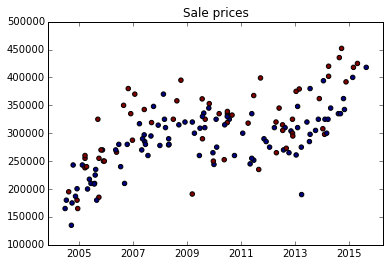

In [13]:
import matplotlib.pyplot as plt

x = sales.date.values
y = sales.docamount.values
t = sales.street.values

plt.title('Sale prices')
plt.scatter(x, y, c=t)
plt.show()
# steps needed to make this pretty
# better color differentiation
# drop top and right borders
# format money correctly 

In [14]:
# will need to do alpha check in case units listed as A1 
sales['line']=[s[-1:] for s in sales.unit]
sales.line.head()

0    A
1    C
2    C
3    D
5    B
Name: line, dtype: object

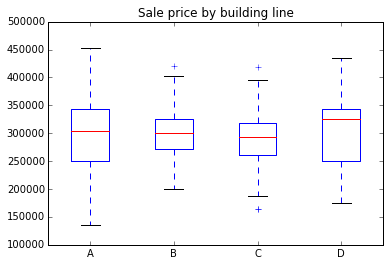

In [15]:
lines=sales.line.unique()
lines.sort()
lines
data = []
for l in lines:
    data.append([sales[sales.line==l].docamount])

plt.boxplot(data,labels=lines)
plt.title('Sale price by building line')
plt.show()

In [16]:
#quick trimming a string down to just digits 
#from: http://stackoverflow.com/questions/1450897/python-removing-characters-except-digits-from-string
import string
all=string.maketrans('','')
nodigs=all.translate(all, string.digits)
#then use as string.translate(all, nodigs)
def justdigits(string):
    return int(string.translate(all,nodigs))
    
# eg justdigits('10A') returns 10 

In [17]:
sales['floor']=[justdigits(s) for s in sales['unit']]
sales.floor.head()

0     4
1    11
2    10
3     5
5     2
Name: floor, dtype: int64

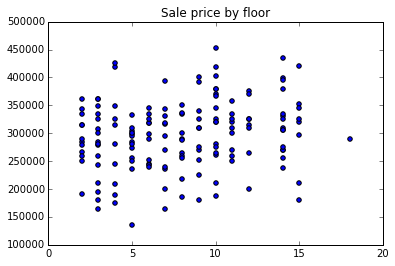

In [18]:
x = sales.floor.values
y = sales.docamount.values

plt.scatter(x,y)
plt.title('Sale price by floor')
plt.show()

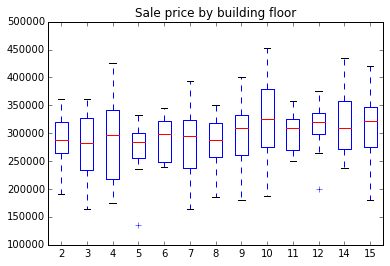

In [19]:
floorcounts=sales.floor.value_counts()
floors=floorcounts[floorcounts>1].index.values
floors.sort()
floors
data = []
for f in floors:
    data.append([sales[sales.floor==f].docamount])
plt.boxplot(data ,labels=floors)
plt.title('Sale price by building floor')
plt.show()

In [29]:
sales = sales.set_index('date').sort_index()

In [30]:
sales.head()

,Unnamed: 0,documentid,recordtype_x,borough_x,block,lot,easement,partiallot,airrights,subterraneanrights,...,recorded/filed,modifieddate,reelyear,reelnbr,reelpage,%transferred,goodthroughdate_y,street,line,floor
date,,,,,,,,,,,,,,,,,,,,,
2004-06-21,19,2006011201300001,L,4,528,50,N,E,N,N,...,01/24/2006,01/24/2006,0,0,0,100,07/31/2015,14,C,7
2004-07-08,78,2004080300906001,L,4,528,50,N,E,N,N,...,08/17/2004,08/17/2004,0,0,0,100,07/31/2015,14,A,15
2004-08-09,88,2004082000656001,L,4,528,50,N,E,N,N,...,09/22/2004,09/22/2004,0,0,0,100,07/31/2015,21,C,3
2004-09-14,84,2004092800386001,L,4,528,50,N,E,N,N,...,10/25/2004,10/25/2004,0,0,0,100,07/31/2015,14,A,5
2004-09-23,159,2004092301700001,L,4,528,50,N,E,N,N,...,10/23/2004,10/23/2004,0,0,0,100,07/31/2015,14,D,4


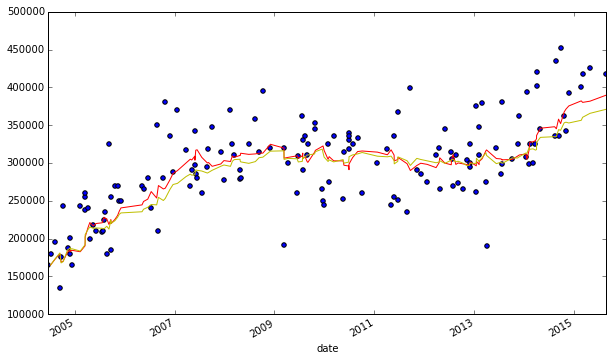

In [164]:
plt.figure(figsize=(10,6))
x=sales.index.values
y=sales.docamount
plt.scatter(x,y)
pd.rolling_mean(sales.docamount,10,min_periods=1).shift(+1).plot(style='r')
pd.ewma(sales.docamount,10,min_periods=1).shift(+1).plot(style='y')
plt.show()

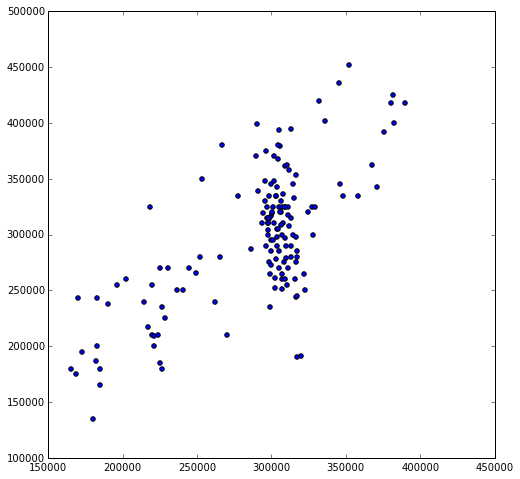

In [94]:
plt.figure(figsize=(8,8))
x=pd.rolling_mean(sales.docamount,10,min_periods=1).shift(+1)
y=sales.docamount
plt.scatter(x,y)

In [135]:
sales['rm']=pd.rolling_mean(sales.docamount,10,min_periods=1).shift(+1)

In [136]:
sales[['docamount','rm']].tail(20)

,docamount,rm
date,,
2014-01-14,308000,311920.2
2014-01-22,394000,304800.0
2014-02-06,298000,316700.0
2014-02-12,325000,327500.0
2014-03-07,300000,328000.0
2014-03-25,325000,329500.0
2014-04-02,420000,332200.0
2014-04-02,402000,336200.0
2014-04-30,345000,345900.0


In [148]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [145]:
sales['bldgnum']=[str(justdigits(s)) for s in sales['streetnumber']]

In [146]:
results = ols(formula="docamount ~ rm + line + floor + bldgnum + line*bldgnum", data=sales).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              docamount   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     17.01
Date:                Sun, 01 Nov 2015   Prob (F-statistic):           3.08e-30
Time:                        21:38:34   Log-Likelihood:                -1768.9
No. Observations:                 152   AIC:                             3596.
Df Residuals:                     123   BIC:                             3684.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------
Intercept                 -3.538e+04   2.04e+04     -1.738      0.085     -7.57e+04  4921.748
line[T.B]                 -8758.8611   1.49e+04     -0.587      0.558     -3.83e+04  2.08e+04
line[T.C]                  7244.3603   1.55e+04      0.468      0.640     -2.34e+04  3.79e+04
line[T.D]                  2874.1182    1.7e+04      0.169      0.866     -3.08e+04  3.65e+04
bldgnum[T.3347]            4.972e+04   1.61e+04      3.092      0.002      1.79e+04  8.15e+04
bldgnum[T.3355]            1.138e+04   1.85e+04      0.614      0.540     -2.53e+04   4.8e+04
bldgnum[T.3360]            5.574e+04   1.55e+04      3.592      0.000       2.5e+04  8.65e+04
bldgnum[T.3364]           -4.736e+04    1.7e+04     -2.781      0.006     -8.11e+04 -1.36e+04
bldgnum[T.3365]           -1.855e+04   1.48e+04     -1.253      0.213     -4.79e+04  1.08e+04
bldgnum[T.3368]                3e+04   1.54e+04      1.952      0.053      -415.199  6.04e+04
line[T.B]:bldgnum[T.3347] -8893.3131   2.65e+04     -0.336      0.738     -6.13e+04  4.35e+04
line[T.C]:bldgnum[T.3347]  2.106e+04   2.98e+04      0.706      0.481     -3.79e+04  8.01e+04
line[T.D]:bldgnum[T.3347] -1.255e+04   3.02e+04     -0.416      0.678     -7.23e+04  4.72e+04
line[T.B]:bldgnum[T.3355]  3652.7452   2.53e+04      0.144      0.886     -4.65e+04  5.38e+04
line[T.C]:bldgnum[T.3355] -2.251e+04   2.44e+04     -0.924      0.357     -7.07e+04  2.57e+04
line[T.D]:bldgnum[T.3355] -1.766e+04   2.67e+04     -0.660      0.510     -7.06e+04  3.53e+04
line[T.B]:bldgnum[T.3360] -3213.8597   2.34e+04     -0.137      0.891     -4.96e+04  4.32e+04
line[T.C]:bldgnum[T.3360] -1.087e+04   2.39e+04     -0.455      0.650     -5.82e+04  3.65e+04
line[T.D]:bldgnum[T.3360]  5478.7121   2.33e+04      0.235      0.814     -4.06e+04  5.16e+04
line[T.B]:bldgnum[T.3364]  6.484e+04   2.45e+04      2.644      0.009      1.63e+04  1.13e+05
line[T.C]:bldgnum[T.3364]  5.498e+04   2.32e+04      2.375      0.019      9152.130  1.01e+05
line[T.D]:bldgnum[T.3364]  -1.46e-08   1.35e-08     -1.082      0.281     -4.13e-08  1.21e-08
line[T.B]:bldgnum[T.3365]  5224.6908   2.17e+04      0.241      0.810     -3.77e+04  4.82e+04
line[T.C]:bldgnum[T.3365] -6522.9050   2.26e+04     -0.289      0.773     -5.13e+04  3.82e+04
line[T.D]:bldgnum[T.3365]  1.644e+04   2.37e+04      0.694      0.489     -3.04e+04  6.33e+04
line[T.B]:bldgnum[T.3368]  5.576e+04   2.32e+04      2.404      0.018      9838.890  1.02e+05
line[T.C]:bldgnum[T.3368] -8552.4656    2.9e+04     -0.295      0.769      -6.6e+04  4.89e+04
line[T.D]:bldgnum[T.3368] -3149.8826   2.71e+04     -0.116      0.908     -5.68e+04  5.05e+04
rm                            1.0123      0.057     17.763      0.000         0.900     1.125
floor                      3122.7402    669.458      4.665      0.000      

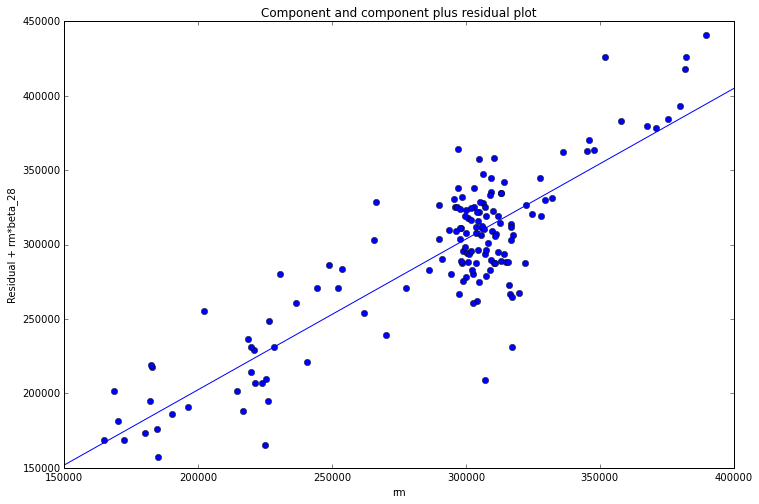

In [156]:
fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_ccpr(results, "rm", ax=ax)

In [165]:
qpluto = pd.read_csv('QN.csv')

/Users/helene/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (6,7,10,11,50,52,53,77,79) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [169]:
qcoops = qpluto[qpluto.BldgClass=='D4']

In [186]:
qcoops.sort(['UnitsRes'],ascending=0)[['Borough','Block','Lot','NumBldgs','NumFloors','UnitsRes']].head(20)


,Borough,Block,Lot,NumBldgs,NumFloors,UnitsRes
279535,QN,12495,2,28,14,5860
176713,QN,8489,1,8,34,1844
51900,QN,2086,50,7,14,1094
25185,QN,1111,1,11,6,966
149971,QN,6790,1,32,6,793
7181,QN,557,3,14,15,727
54968,QN,2314,1,6,18,706
320478,QN,16131,1,4,13,687
149981,QN,6792,600,31,6,684
321162,QN,16175,1,3,12,651


## Proposal / next steps

### Create a model to predict prices of individual co-op units

Using historical sales and other data build a model to best predict current sales prices for NYC co-op apartments.  ACRIS public data will form the core dataset. Features may include prior sales, floor and line of the unit, time since last sale, and adjustments for overall neighborhood and borough trends.

### Next steps

- Setup data caching - data is saved to disk and only re-pulled if there are new results
- Look at frequency of sales and start testing moving averages, look back windows to see what appears useful and stable
- With something reasonably stable try basic regression including floor and unit, proxy for apartment size where we have it, see how close we are with simple models
- Bring and test with more data - other co-ops, make decision about working on multiple or just one
- Explore other models of price over time - e.g. exponential decay 
- Figure out how to bring in neighborhood and borough trends as feature, figure out best weighting between co-op specific and neighborhood, borough, city level factors. 
- Other data sources? 
- Test and compare various models 
- Think about how to productionalize 

In [20]:
# look into this post for function to do rolling mean by a time period
# rather than number of data points
# http://stackoverflow.com/questions/15771472/pandas-rolling-mean-by-time-interval
